In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, date, timedelta
from scipy import stats
import seaborn as sns
import plotly.express as px

In [2]:
salesDf = pd.read_csv("data/sales_train_evaluation.csv")

In [3]:
salesDf.head()

id        item_id    dept_id   cat_id store_id  \
0  HOBBIES_1_001_CA_1_evaluation  HOBBIES_1_001  HOBBIES_1  HOBBIES     CA_1   
1  HOBBIES_1_002_CA_1_evaluation  HOBBIES_1_002  HOBBIES_1  HOBBIES     CA_1   
2  HOBBIES_1_003_CA_1_evaluation  HOBBIES_1_003  HOBBIES_1  HOBBIES     CA_1   
3  HOBBIES_1_004_CA_1_evaluation  HOBBIES_1_004  HOBBIES_1  HOBBIES     CA_1   
4  HOBBIES_1_005_CA_1_evaluation  HOBBIES_1_005  HOBBIES_1  HOBBIES     CA_1   

  state_id  d_1  d_2  d_3  d_4  ...  d_1932  d_1933  d_1934  d_1935  d_1936  \
0       CA    0    0    0    0  ...       2       4       0       0       0   
1       CA    0    0    0    0  ...       0       1       2       1       1   
2       CA    0    0    0    0  ...       1       0       2       0       0   
3       CA    0    0    0    0  ...       1       1       0       4       0   
4       CA    0    0    0    0  ...       0       0       0       2       1   

   d_1937  d_1938  d_1939  d_1940  d_1941  
0       0       3       3       0       1  
1       0       0       0       0       0  
2       0       2       3       0       1  
3       1       3       0       2       6  
4       0       0       2       1       0  

[5 rows x 1947 columns]

In [4]:
## Useful Globals
start_Date = datetime.strptime('2011-01-29', '%Y-%M-%d').date() ## The starting point of our dates
dateRange = list(pd.date_range(start_Date ,start_Date+timedelta(days=salesDf.shape[1]-7),freq='d'))

# My Understanding
## Columns
- id : a unique product id from a specific store (10 stores, 3049 products = 30490 rows)
- item_id : a product
- dept_id : department id
- cat_id : category id
- d_1 ~ d_1941 : the number of sales for day 1 through day 1941 per product

## Factors that could influence the sales
- Product Type (department, category)
- Location
- Seasonality
- - By Week
  - By Month
- Events (ie valentines, christmas, ...)
- Sales Discounts

## Plan
The plan here would be to evaluate the different factors in order to see which play a factor and to what extend in order to define what we would want our model to look like. We will start by going through the factors to identify which play a part in sales, and which do not

#### Making some helper functions

In [5]:
## Pass in a df with the columns being id, .... ,d_1~d_xx
## Returns a df with 2 columns "dates" and "sales", aggregates all the rows into 1 sales
def dateDf(df):
    nuDf = pd.DataFrame()
    nuDf['date'] = pd.date_range(start_Date ,start_Date+timedelta(days=df.shape[1]-7),freq='d').to_list()
    nuDf['sales'] = df.iloc[:, 6:].sum().to_list()
    return nuDf

## give a column value, dataframe, column, and period
## Returns a sales graph with the values matching the column value in the column in periods
def graphSales(colValue, df, col = 'id', period = 7):
    df = df[df[col] == colValue]
    df = dateDf(df)
    df['date'] = df['date'] - pd.to_timedelta(period, unit='d')
    sums = df.groupby([pd.Grouper(key='date', freq= str(period) + 'D')])['sales'].sum()
    df = pd.DataFrame()
    df['date'] = sums.index.to_list()
    df['sales'] = sums.to_list()
    return plt.plot(df["date"], df["sales"])

# Product Type Analysis

In [6]:
## We have categories of items, and within each category we have 2-3 departments
print(salesDf['dept_id'].unique())
print(salesDf['cat_id'].unique())

['HOBBIES_1' 'HOBBIES_2' 'HOUSEHOLD_1' 'HOUSEHOLD_2' 'FOODS_1' 'FOODS_2'
 'FOODS_3']
['HOBBIES' 'HOUSEHOLD' 'FOODS']


We want to verify that groupings have similar trends
This will help us decide whether we want to build our models at the department, category, or item level
We want to make sure there is a high correlation between trend sets to make sure that it would be a good idea to use them
There are a few similarity measures we can use:
- MAPE
- Euclidean
- Dynamic Time Warping
- Pearson Correlation

In [7]:
## Helper Functions
def CreateCorrDf(df, col, zscorenorm = False, maxNorm = False):
    salesList = {}
    for item in df[col].unique():
        salesList[item] = dateDf(df[df[col] == item])['sales'].to_list()
    corrDf = pd.DataFrame(salesList)
    if zscorenorm:
        corrDf = (corrDf - corrDf.mean()) / corrDf.std()
    if maxNorm:
        corrDf = corrDf/corrDf.max()
    return corrDf

## Line graph for items

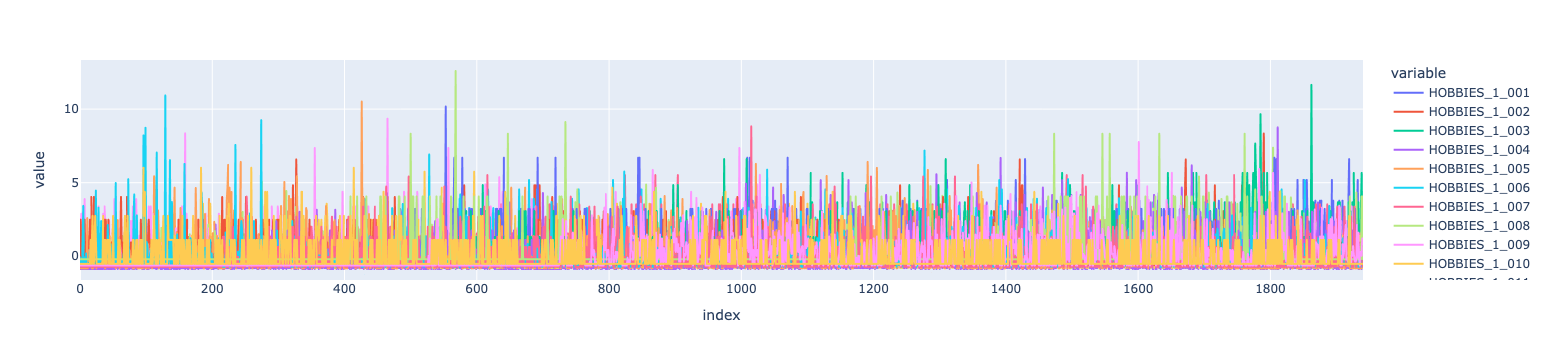

In [15]:
currDf = salesDf[salesDf["dept_id"] == "HOBBIES_1"][:20]
corrDf = CreateCorrDf(currDf, 'item_id', zscorenorm = True)
fig = px.line(corrDf)
fig.show()

## Heatmap for items in a department
I want to see if there is correlation per department based on item (reguardless of location)

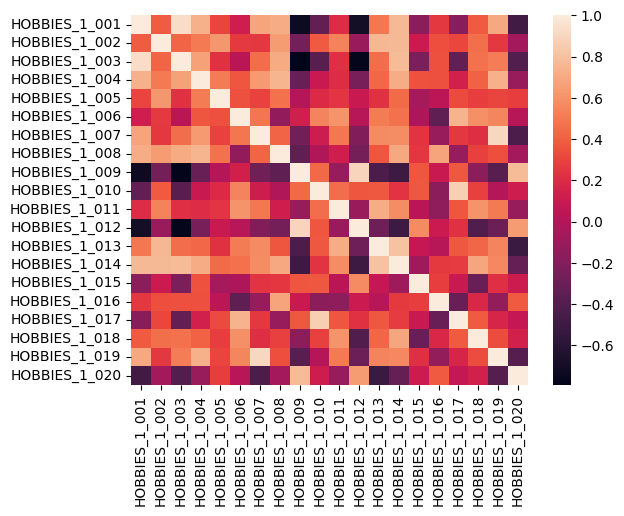

In [9]:
corrDf = corrDf.groupby(corrDf.index // 194).sum()
corr = corrDf.corr(method = 'spearman')
sns.heatmap(corr, annot = False)
plt.show()

## Line graph for Departments

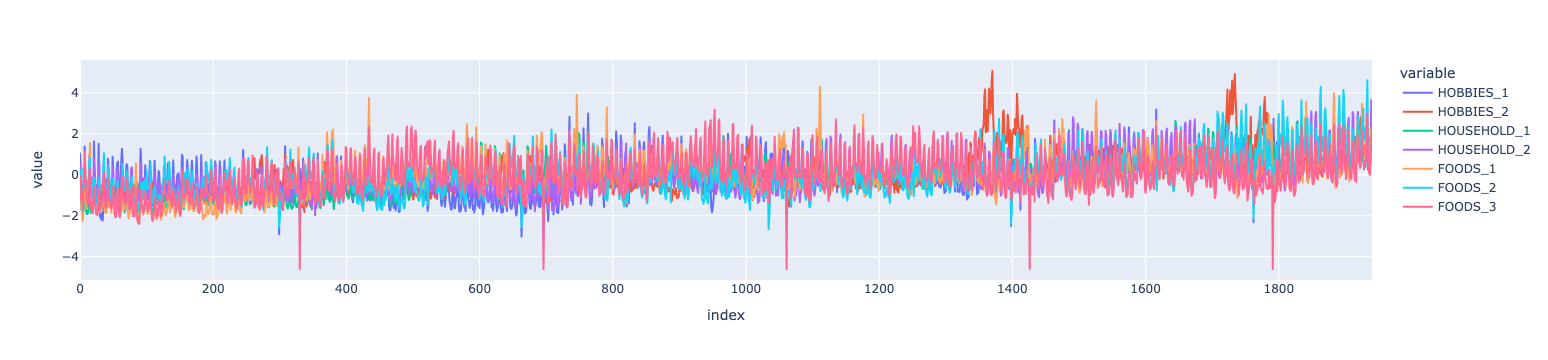

In [16]:
corrDf = CreateCorrDf(salesDf, 'dept_id', zscorenorm = True)
fig = px.line(corrDf)
fig.show()

## Heat map for Departments

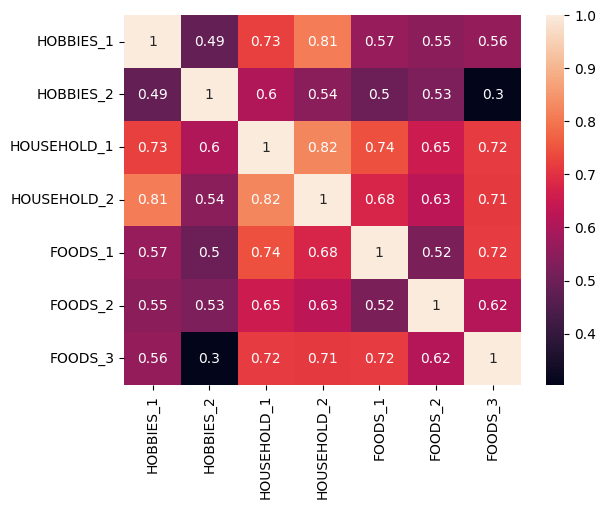

In [11]:
## I want to see if there is correlation per category based on department (reguardless of location)
corrDf = CreateCorrDf(salesDf, 'dept_id')
corr = corrDf.corr(method = 'spearman')
sns.heatmap(corr, annot = True)
plt.show()

## Line graph for categories

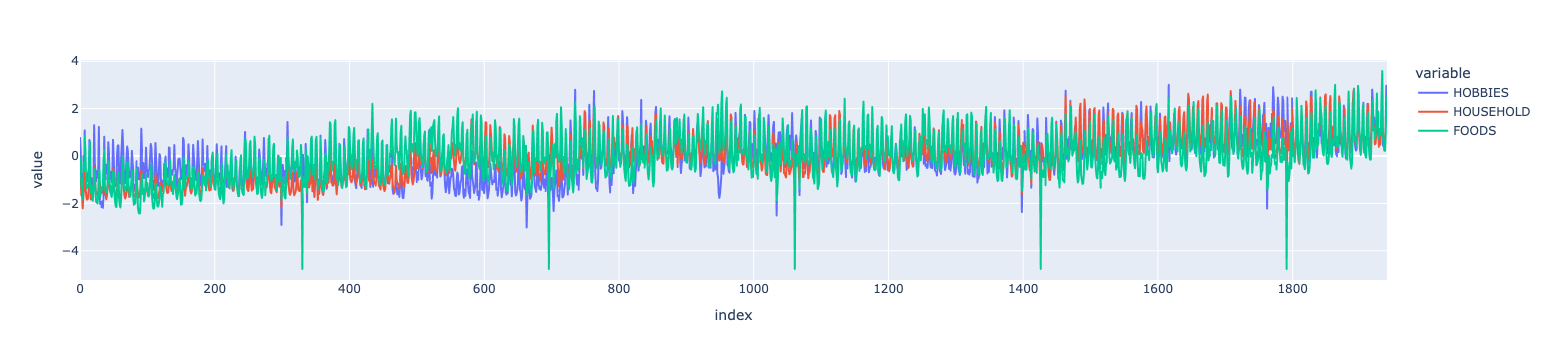

In [17]:
corrDf = CreateCorrDf(salesDf, 'cat_id', zscorenorm = True)
fig = px.line(corrDf)
fig.show()

## Heat maps for Categories

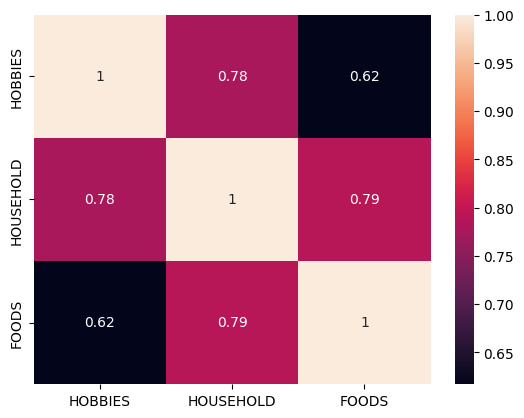

In [13]:
## Looking at correlation between the categories
corrDf = CreateCorrDf(salesDf, 'cat_id')
corr = corrDf.corr(method = 'spearman')
sns.heatmap(corr, annot = True)
plt.show()

# Location